In [1]:
try:
    import numpy as np
except:
    %pip install numpy
      
import pandas as pd
import matplotlib.pyplot as plt
#import latexify as lt
import scipy.signal as signal

#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [2]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

## Indoor

In [98]:
df = pd.read_csv("Data Collection/021_outdoor.csv", names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)
sr = 1 #as per sensor specification

Text(0, 0.5, 'CO$_2$ Data (in ppm)')

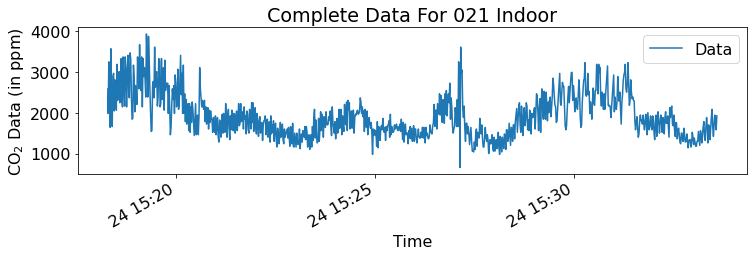

In [99]:

ax = df.plot(title="Complete Data For 021 Indoor", figsize=(12,3))
ax.set_xlabel('Time')
ax.set_ylabel('CO$_2$ Data (in ppm)')

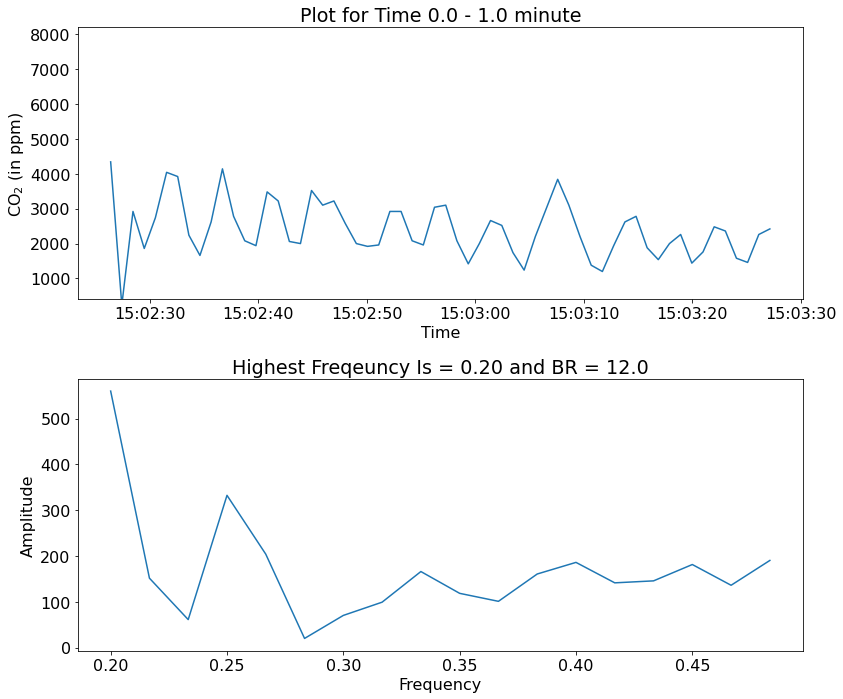

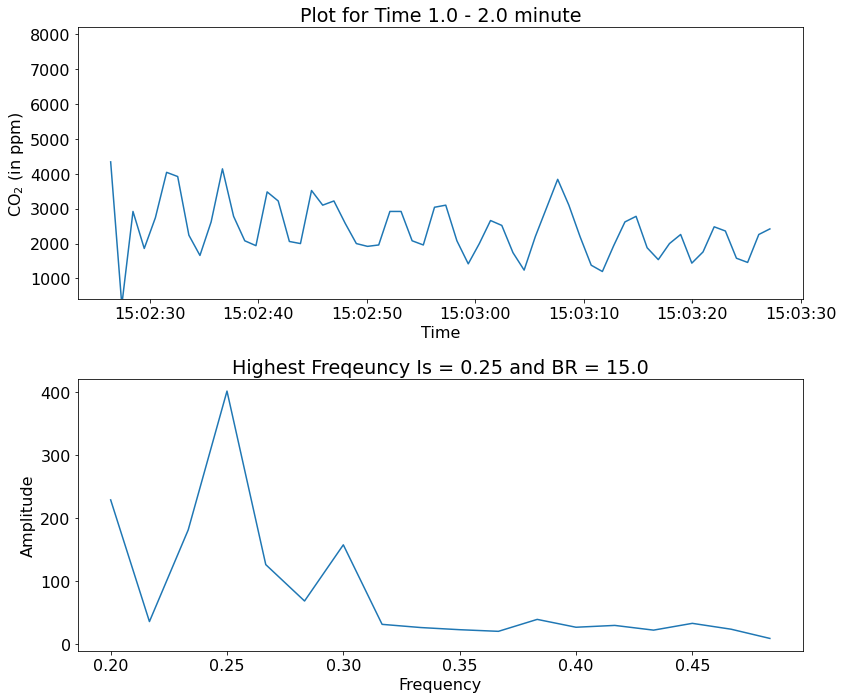

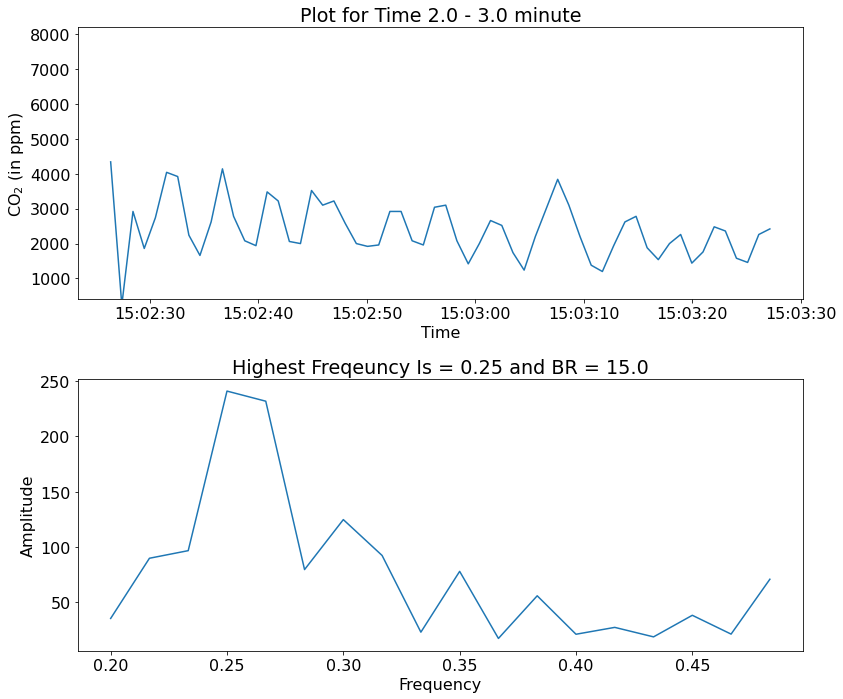

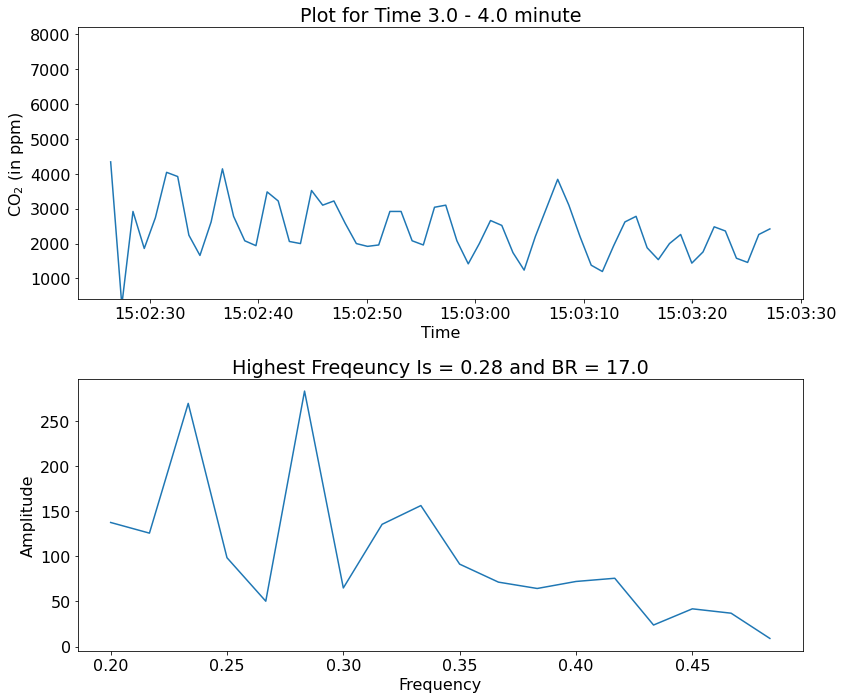

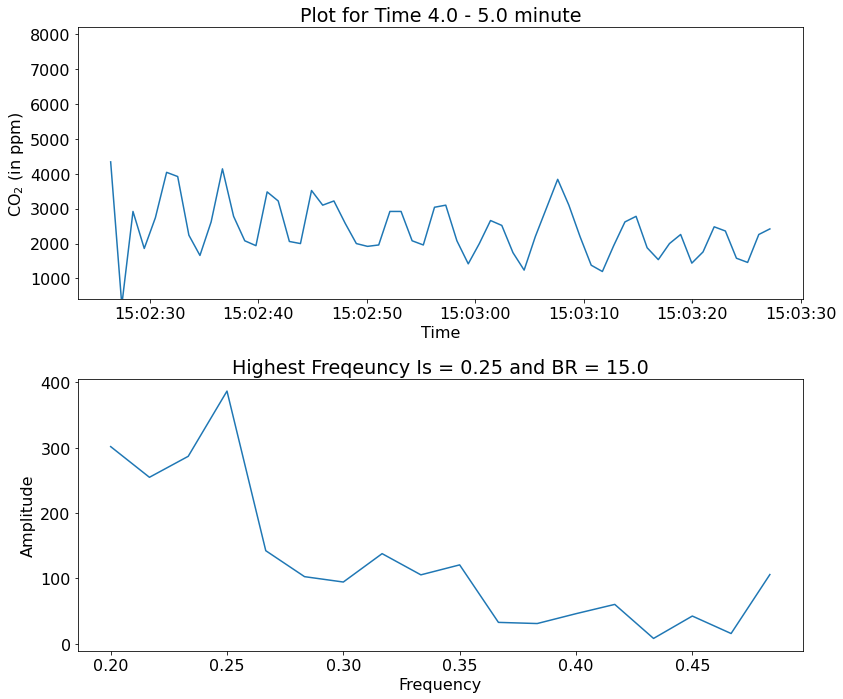

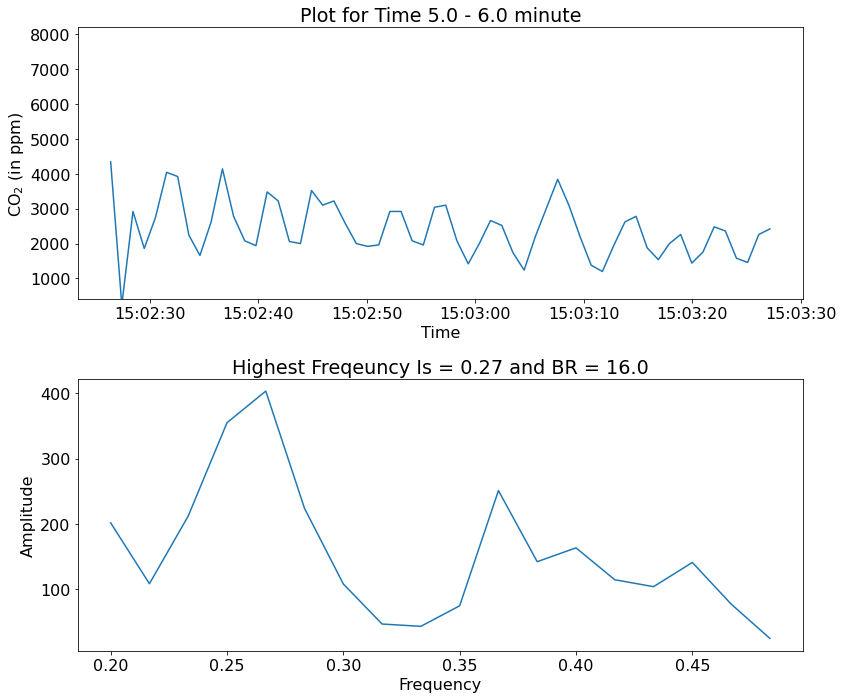

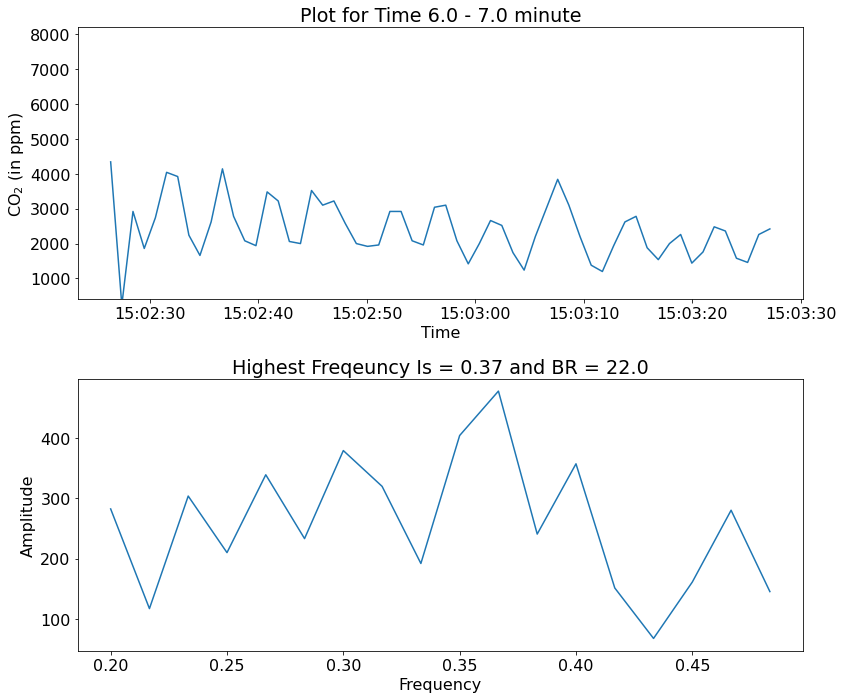

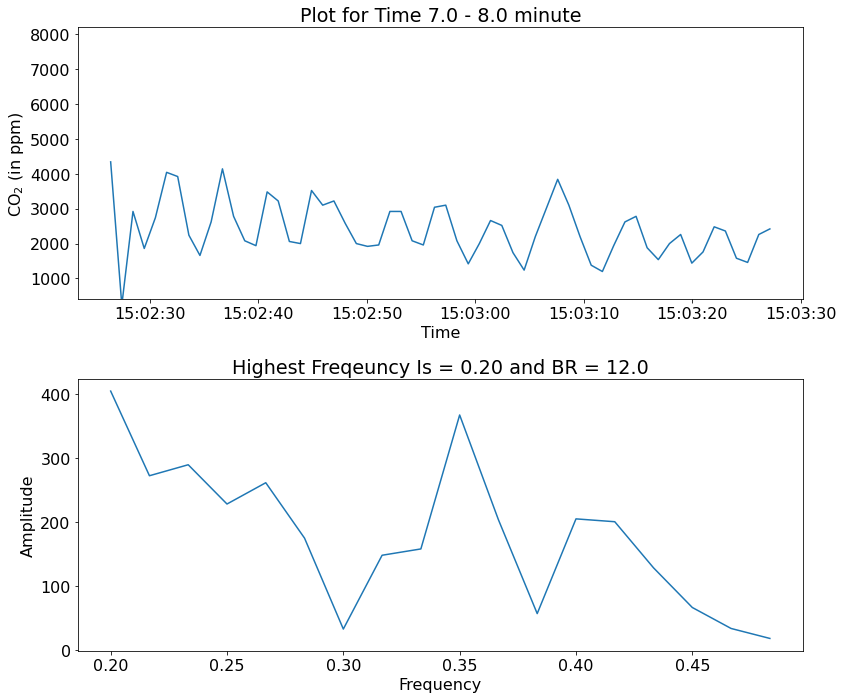

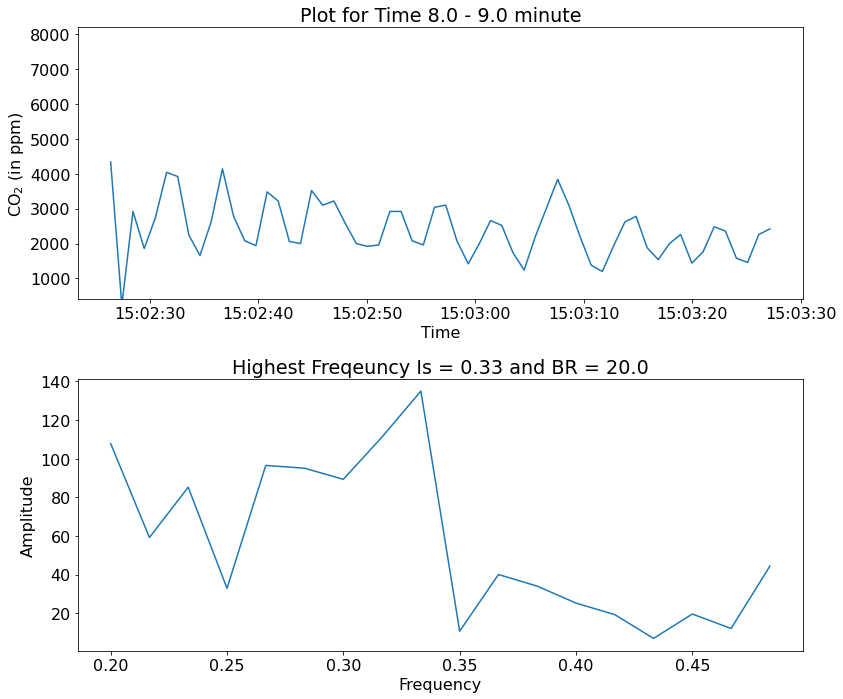

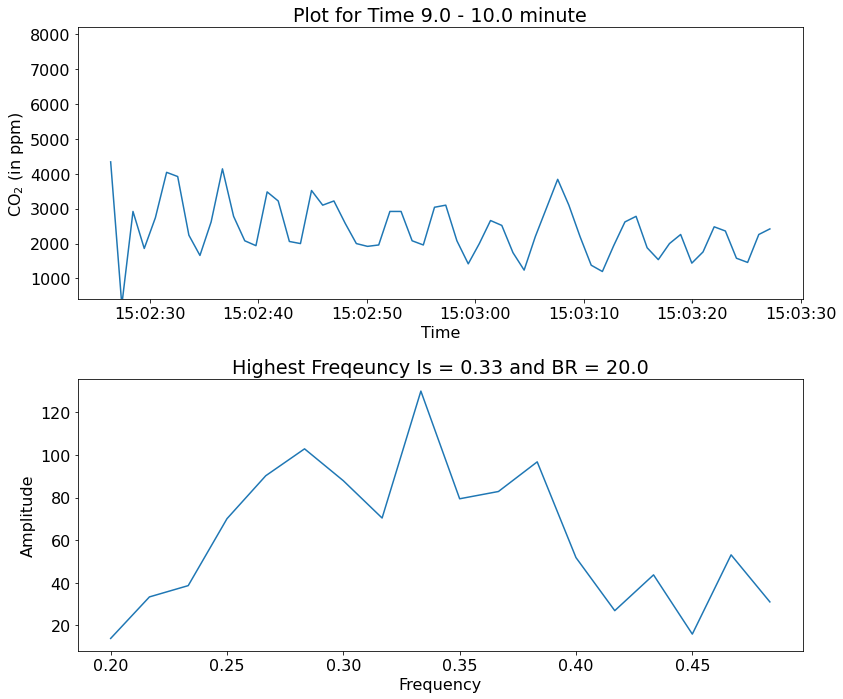

In [48]:
df = pd.read_csv("Data Collection/021_indoor.csv", names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)
sr = 1 #as per sensor specification

#set the timestamp of events
timeStamps = [(i, i+60) for i in range(0,600,60)]

plotID = 0
BrPMList = []
co2avg = []

for startTime, endTime in timeStamps:
    freqToSkip = 12
    data = np.array(df.iloc[startTime:endTime]).reshape(endTime-startTime)
    F,A = compute_fft(data, sr, n = None, scale_amplitudes = True)
    
    fig, ax = plt.subplots(2,1, figsize=(12,10))
    ax[0].plot(df.iloc[0:(endTime-startTime)])
    ax[0].set_title("Plot for Time {} - {} minute".format(startTime/60, endTime/60))
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('CO$_2$ (in ppm)')
    ax[0].set_ylim(400,8192)
    ax[1].plot(F[freqToSkip:],A[freqToSkip:])
    ax[1].set_title("Highest Freqeuncy Is = {:.2f} and BR = {}".format(F[np.argmax(A[freqToSkip:])+freqToSkip],F[np.argmax(A[freqToSkip:])+freqToSkip]*60))
    ax[1].set_ylabel('Amplitude')
    ax[1].set_xlabel('Frequency')
    
    BrPMList.append(F[np.argmax(A[freqToSkip:])+freqToSkip]*60)
    co2avg.append(np.mean(data))
    fig.tight_layout()


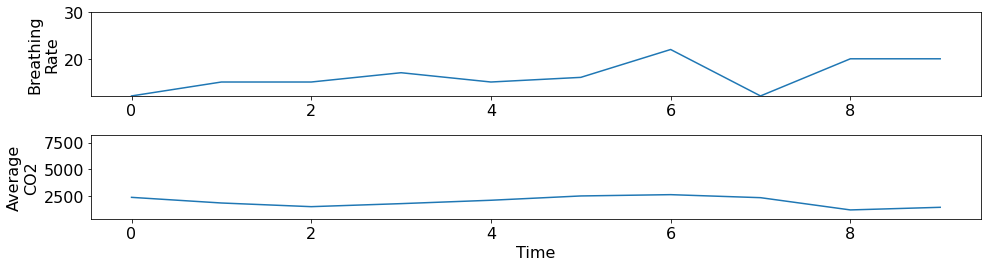

In [32]:
#joseph
# breathing rate over time and
# average co2 over time
fig, ax = plt.subplots(2,1, figsize=(14,4))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30)
ax[0].set_ylabel('Breathing\nRate')
ax[1].plot(co2avg)
ax[1].set_ylim(400,8192)
ax[1].set_ylabel('Average\nCO2')
ax[1].set_xlabel('Time')
fig.tight_layout()

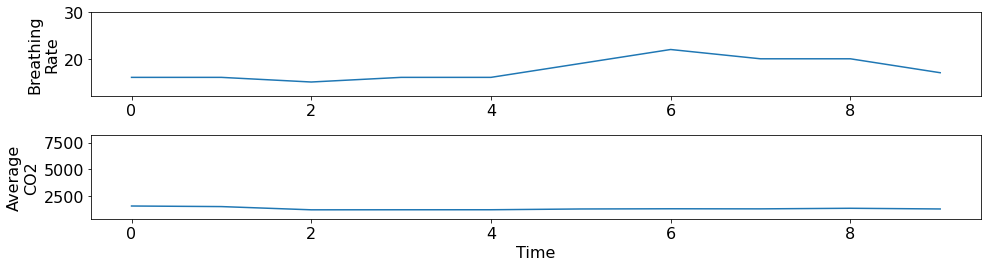

In [30]:
#aryan
# breathing rate over time and
# average co2 over time
fig, ax = plt.subplots(2,1, figsize=(14,4))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30)
ax[0].set_ylabel('Breathing\nRate')
ax[1].plot(co2avg)
ax[1].set_ylim(400,8192)
ax[1].set_ylabel('Average\nCO2')
ax[1].set_xlabel('Time')
fig.tight_layout()

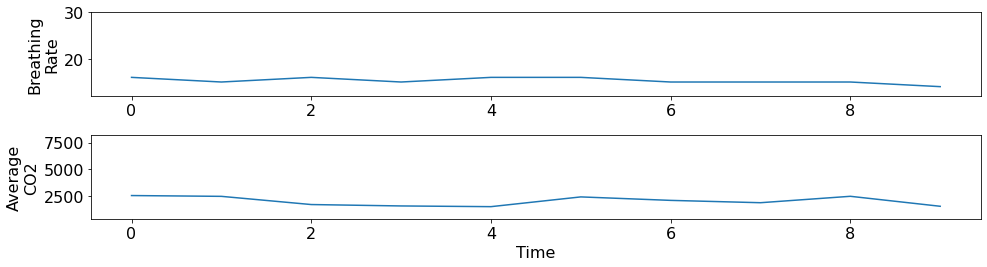

In [28]:
#aabhas
# breathing rate over time and
# average co2 over time
fig, ax = plt.subplots(2,1, figsize=(14,4))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30)
ax[0].set_ylabel('Breathing\nRate')
ax[1].plot(co2avg)
ax[1].set_ylim(400,8192)
ax[1].set_ylabel('Average\nCO2')
ax[1].set_xlabel('Time')
fig.tight_layout()

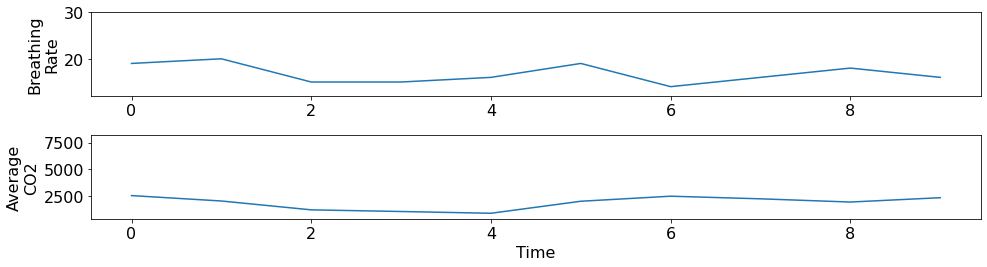

In [26]:
#rishiraj
# breathing rate over time and
# average co2 over time
fig, ax = plt.subplots(2,1, figsize=(14,4))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30)
ax[0].set_ylabel('Breathing\nRate')
ax[1].plot(co2avg)
ax[1].set_ylim(400,8192)
ax[1].set_ylabel('Average\nCO2')
ax[1].set_xlabel('Time')
fig.tight_layout()

## Outdoor

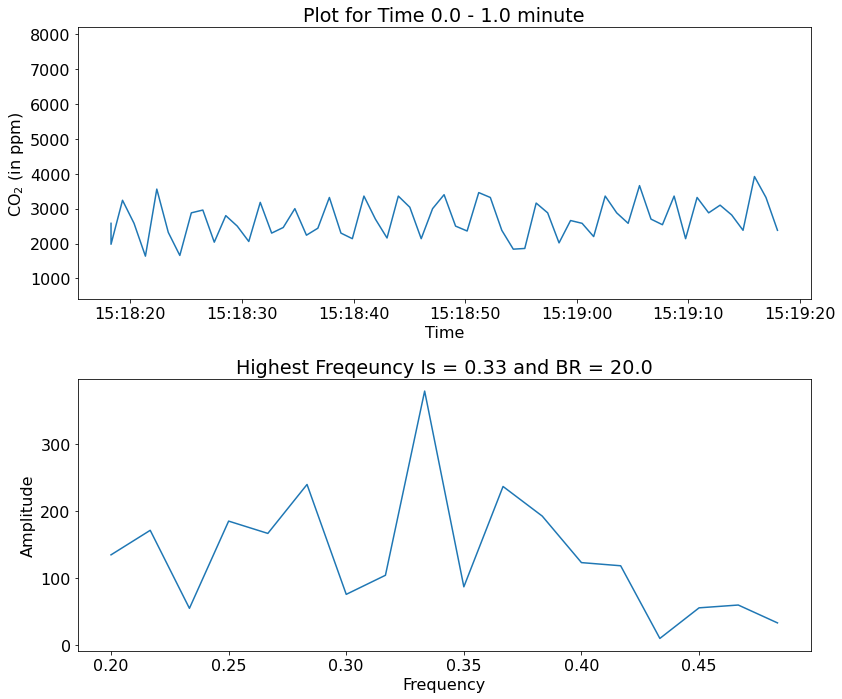

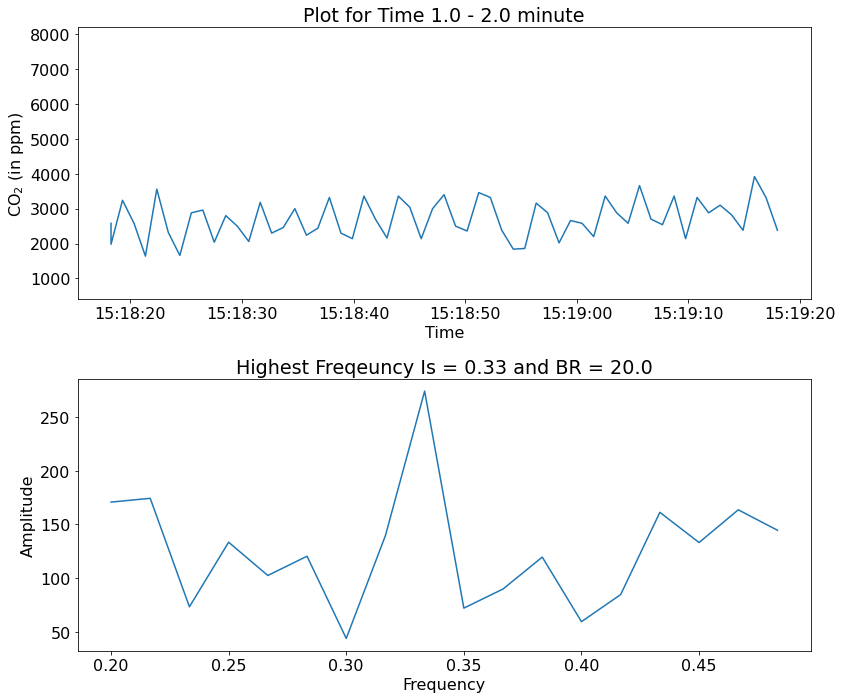

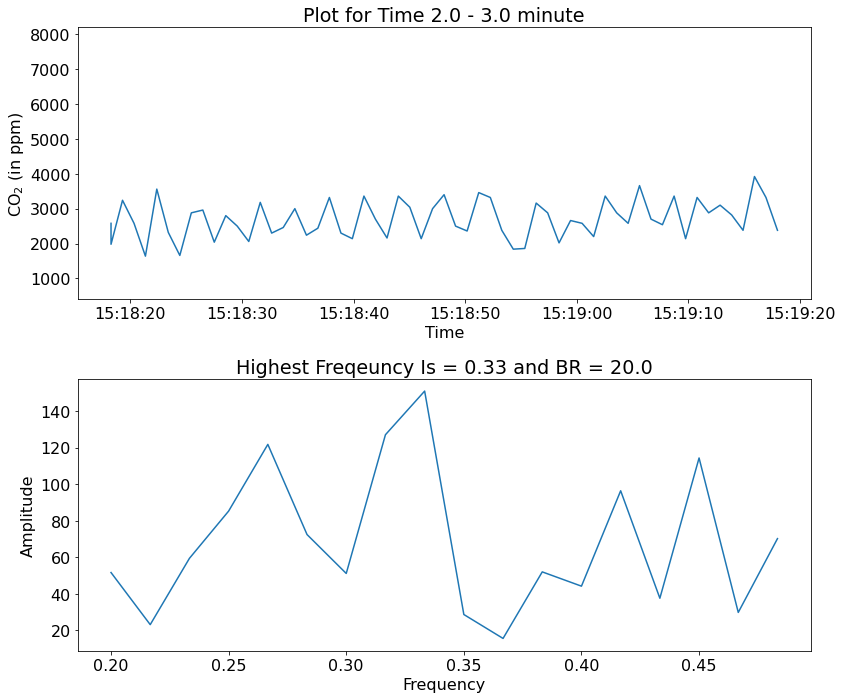

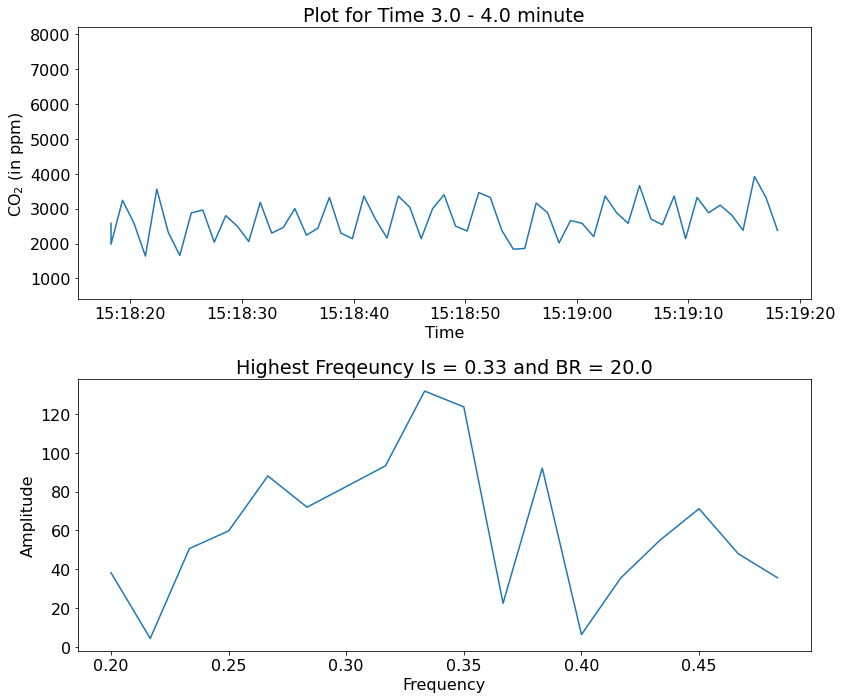

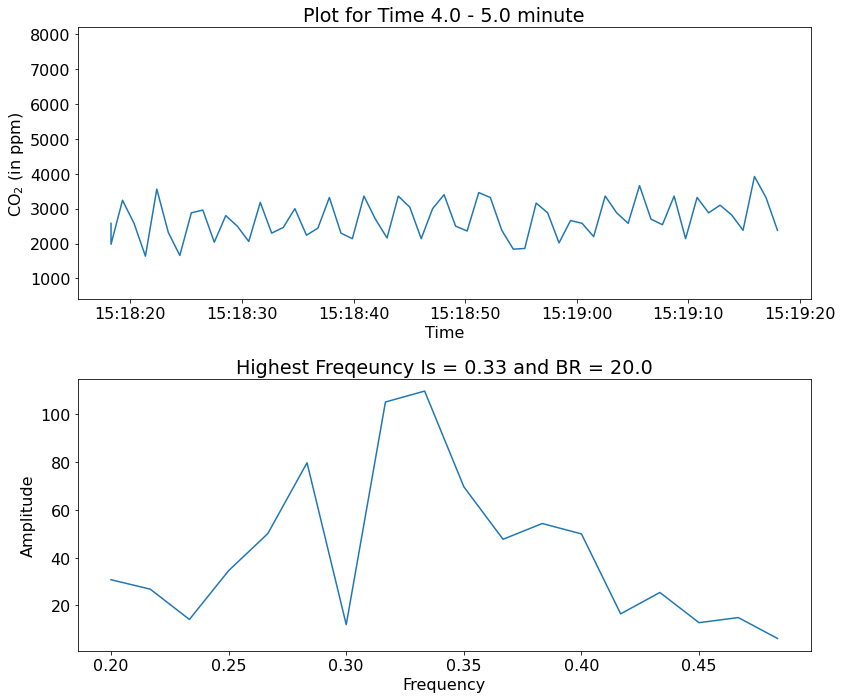

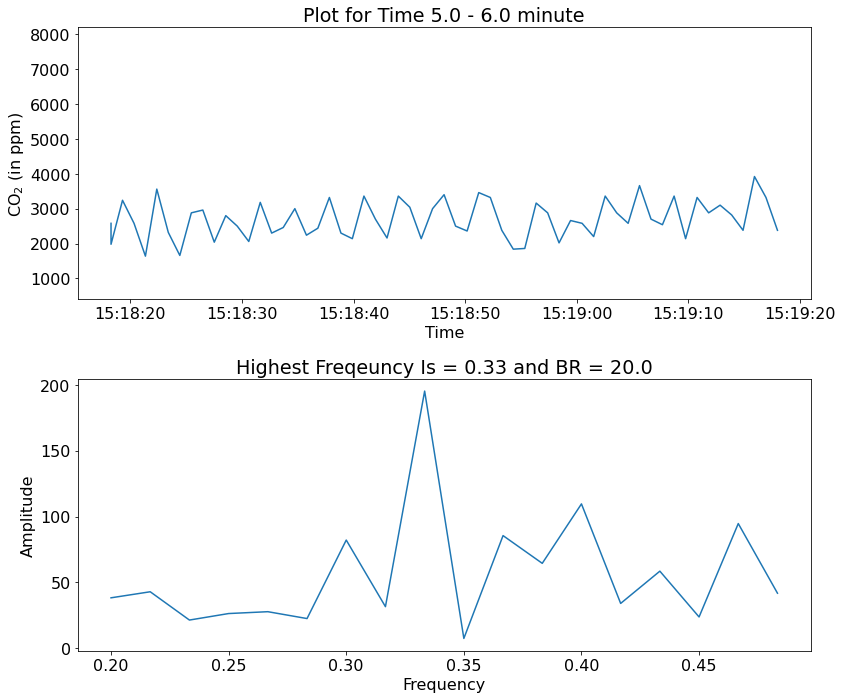

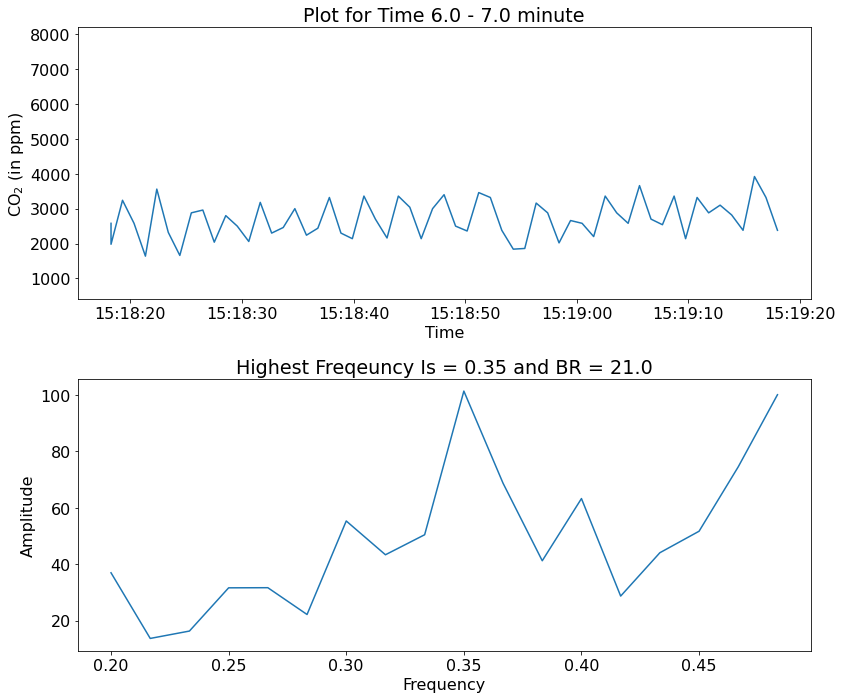

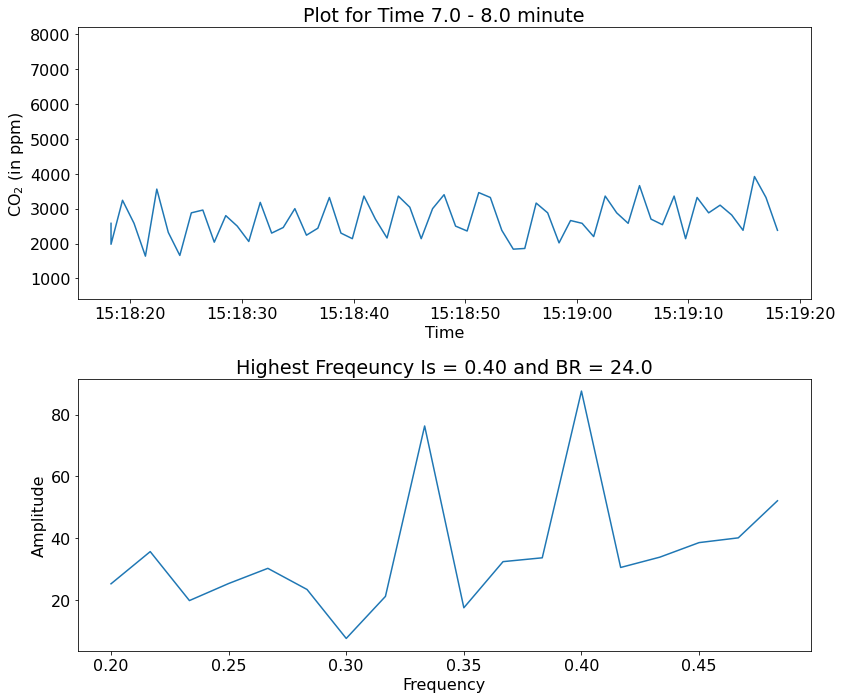

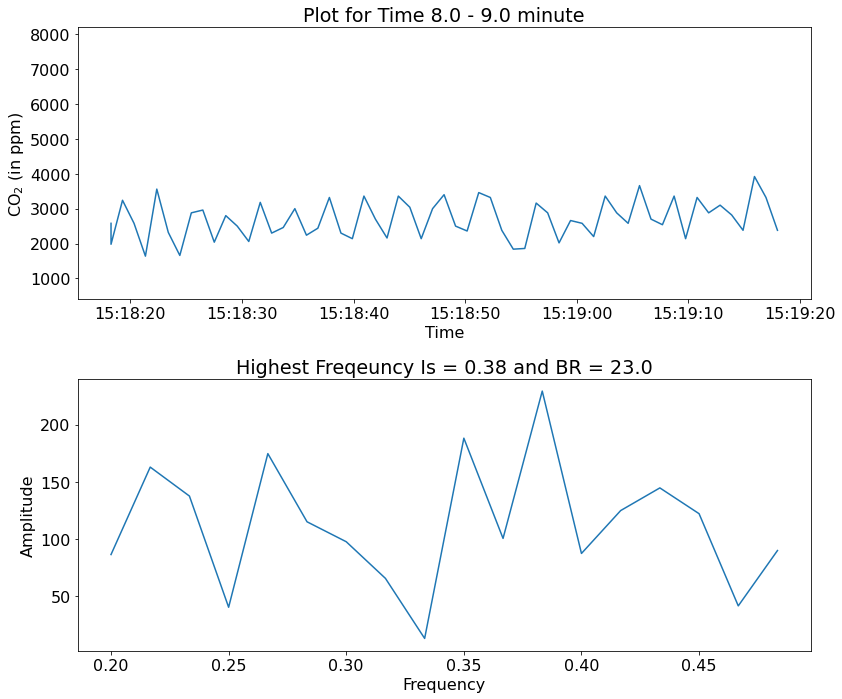

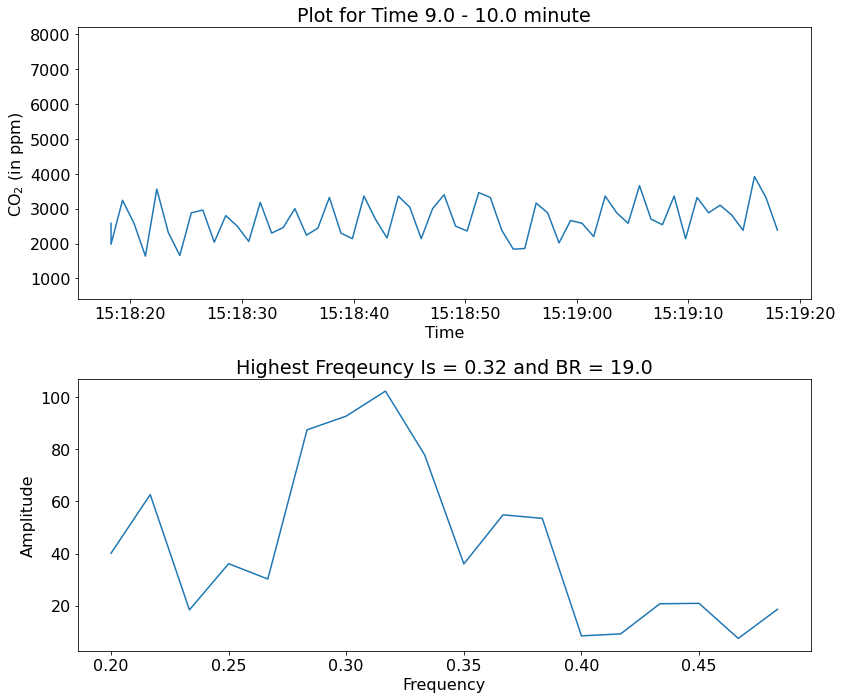

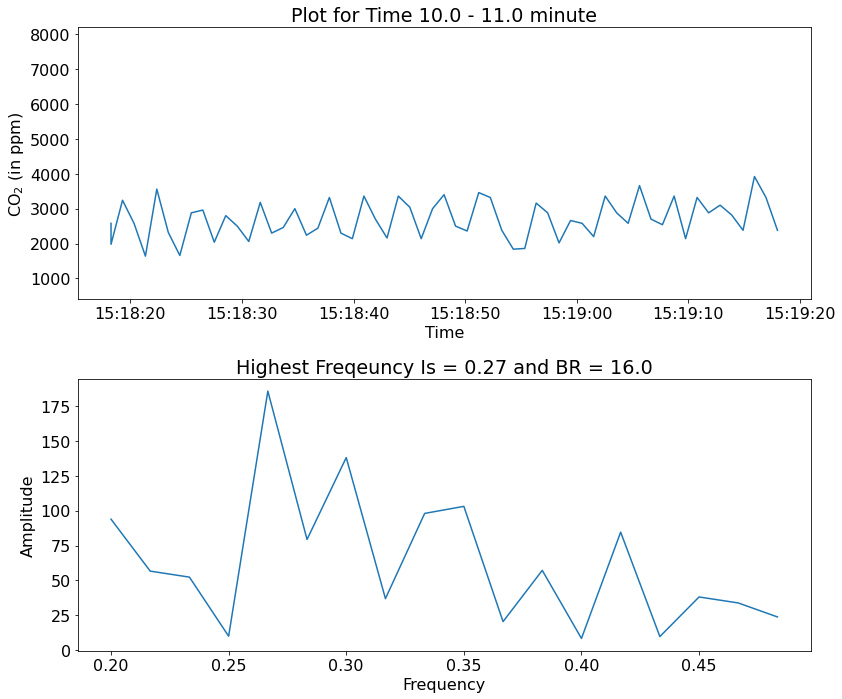

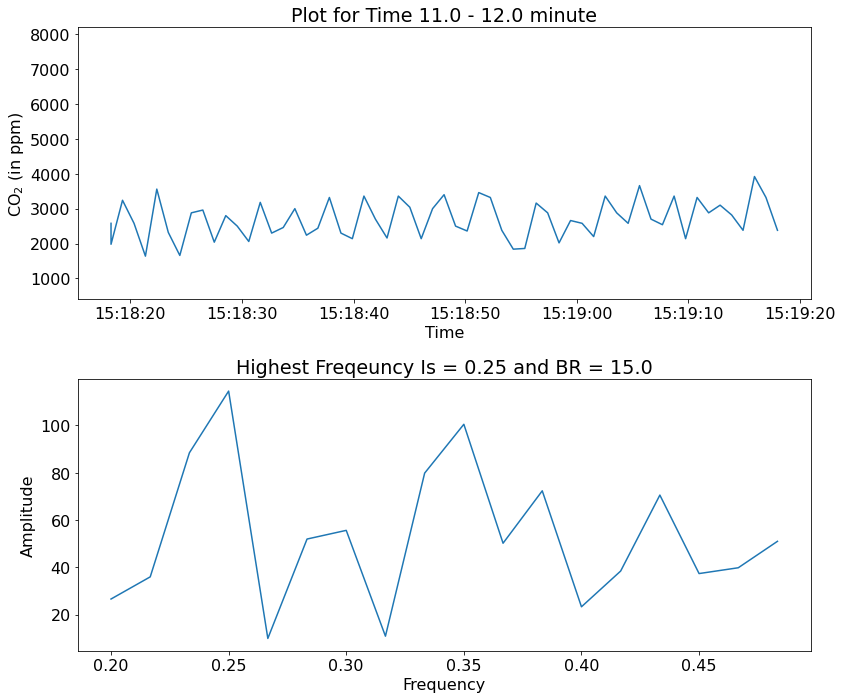

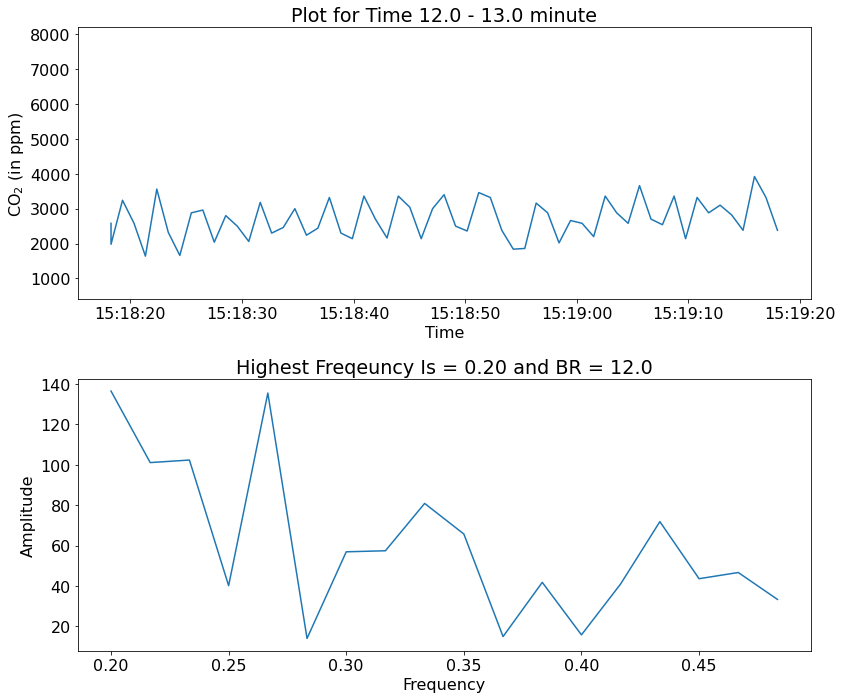

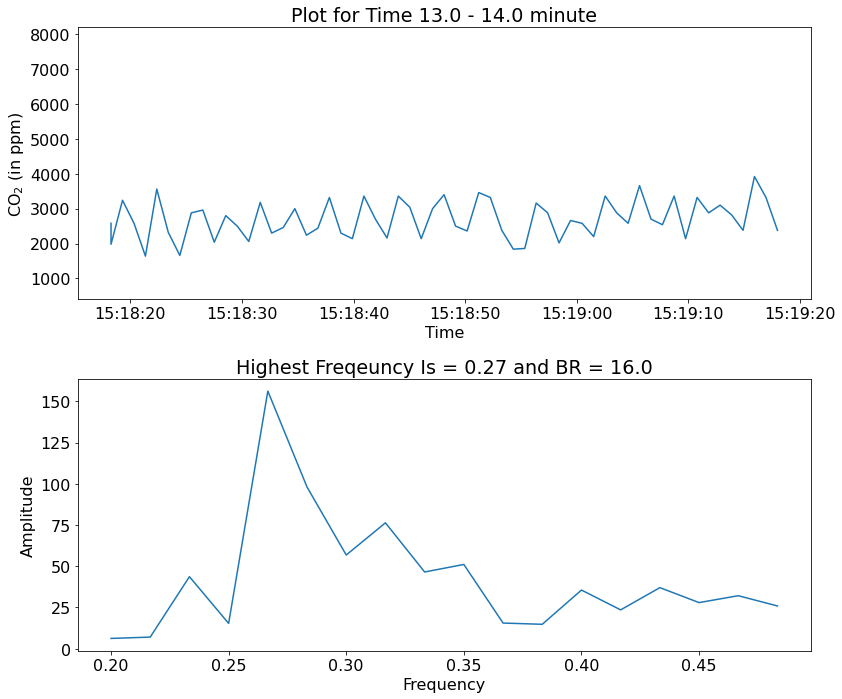

In [47]:
df = pd.read_csv("Data Collection/021_outdoor.csv", names=['Time','Data'])
df.index = pd.to_datetime(df['Time'])
df = df.drop(['Time'],axis=1)
sr = 1 #as per sensor specification

#set the timestamp of events
timeStamps = [(i, i+60) for i in range(0,840,60)]

BrPMList = []
co2List = []

for startTime, endTime in timeStamps:
    freqToSkip = 12
    data = np.array(df.iloc[startTime:endTime]).reshape(endTime-startTime)
    F,A = compute_fft(data, sr, n = None, scale_amplitudes = True)
    
    
    fig, ax = plt.subplots(2,1, figsize=(12,10))
    ax[0].plot(df.iloc[0:(endTime-startTime)])
    ax[0].set_title("Plot for Time {} - {} minute".format(startTime/60, endTime/60))
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('CO$_2$ (in ppm)')
    ax[0].set_ylim(400,8192)
    ax[1].plot(F[freqToSkip:],A[freqToSkip:])
    ax[1].set_title("Highest Freqeuncy Is = {:.2f} and BR = {}".format(F[np.argmax(A[freqToSkip:])+freqToSkip],F[np.argmax(A[freqToSkip:])+freqToSkip]*60))
    ax[1].set_ylabel('Amplitude')
    ax[1].set_xlabel('Frequency')
    fig.tight_layout()
    
    BrPMList.append(F[np.argmax(A[freqToSkip:])+freqToSkip]*60)
    co2List.append((np.mean(data)))

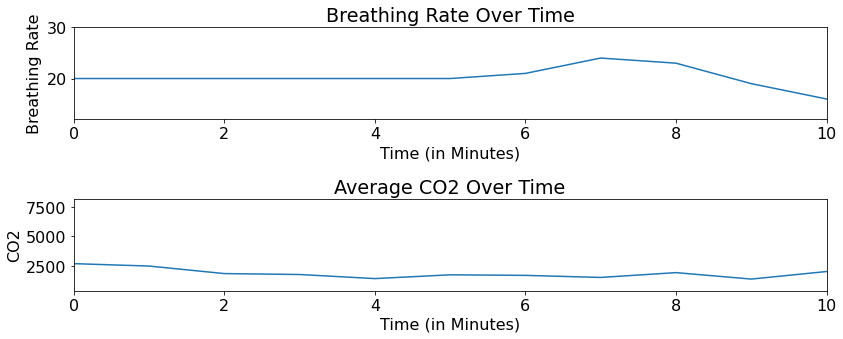

In [40]:
#joseph 21
fig, ax = plt.subplots(2,1, figsize=(12,5))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30) #normal breathing rate range
ax[0].set_xlim(0,10)
ax[0].set_title("Breathing Rate Over Time")
ax[0].set_ylabel("Breathing Rate")
ax[0].set_xlabel("Time (in Minutes)")

ax[1].plot(co2List)
ax[1].set_title("Average CO2 Over Time")
ax[1].set_ylabel("CO2")
ax[1].set_ylim(400, 8192)
ax[1].set_xlabel("Time (in Minutes)")
ax[1].set_xlim(0,10)
fig.tight_layout()

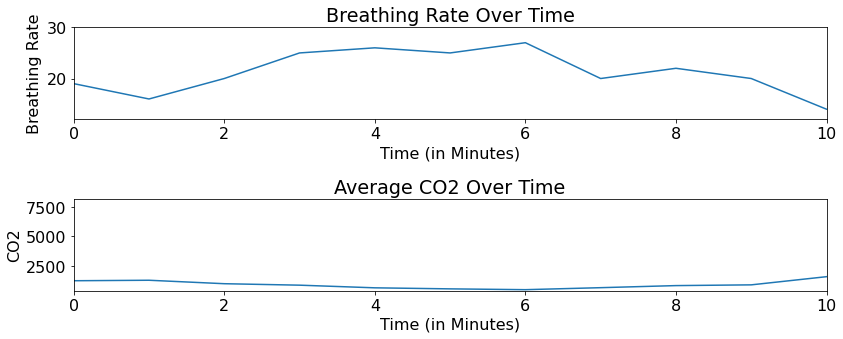

In [42]:
#aryan 22
fig, ax = plt.subplots(2,1, figsize=(12,5))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30) #normal breathing rate range
ax[0].set_xlim(0,10)
ax[0].set_title("Breathing Rate Over Time")
ax[0].set_ylabel("Breathing Rate")
ax[0].set_xlabel("Time (in Minutes)")

ax[1].plot(co2List)
ax[1].set_title("Average CO2 Over Time")
ax[1].set_ylabel("CO2")
ax[1].set_ylim(400, 8192)
ax[1].set_xlabel("Time (in Minutes)")
ax[1].set_xlim(0,10)
fig.tight_layout()

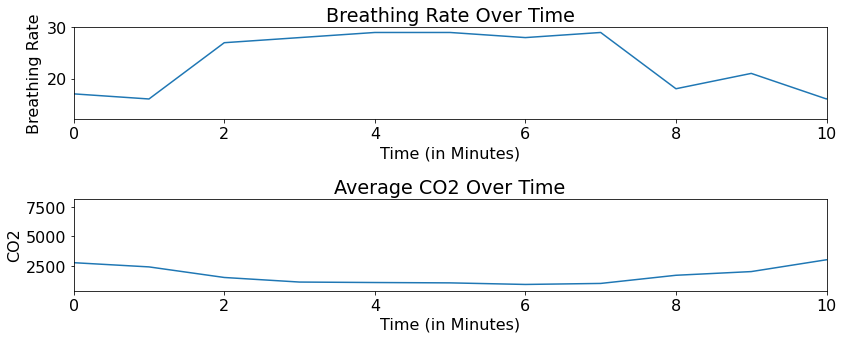

In [44]:
#aabhas 23
fig, ax = plt.subplots(2,1, figsize=(12,5))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30) #normal breathing rate range
ax[0].set_xlim(0,10)
ax[0].set_title("Breathing Rate Over Time")
ax[0].set_ylabel("Breathing Rate")
ax[0].set_xlabel("Time (in Minutes)")

ax[1].plot(co2List)
ax[1].set_title("Average CO2 Over Time")
ax[1].set_ylabel("CO2")
ax[1].set_ylim(400, 8192)
ax[1].set_xlabel("Time (in Minutes)")
ax[1].set_xlim(0,10)
fig.tight_layout()

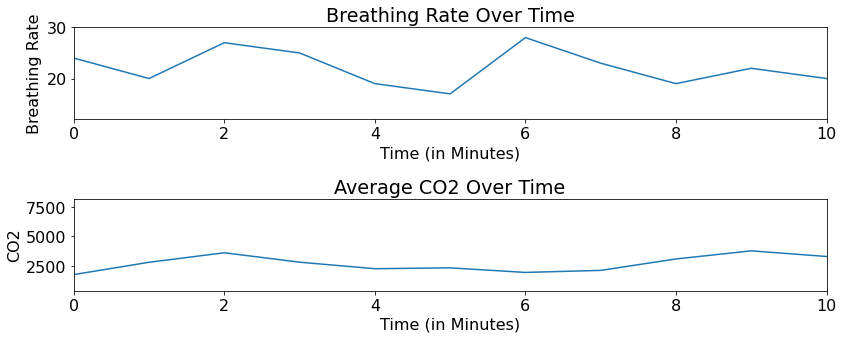

In [46]:
#rishiraj 24
fig, ax = plt.subplots(2,1, figsize=(12,5))
ax[0].plot(BrPMList)
ax[0].set_ylim(12,30) #normal breathing rate range
ax[0].set_xlim(0,10)
ax[0].set_title("Breathing Rate Over Time")
ax[0].set_ylabel("Breathing Rate")
ax[0].set_xlabel("Time (in Minutes)")

ax[1].plot(co2List)
ax[1].set_title("Average CO2 Over Time")
ax[1].set_ylabel("CO2")
ax[1].set_ylim(400, 8192)
ax[1].set_xlabel("Time (in Minutes)")
ax[1].set_xlim(0,10)
fig.tight_layout()